In [1]:
from models.training import Trainer
from models.wmf import WMF
from data.data_transforming import IDEncoder
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

## Use when you would like to init model ↓

In [3]:
users_df = pd.read_json('data_files/users.jsonl', lines=True)
tracks_df = pd.read_json('data_files/tracks.jsonl', lines=True)
user_encoder = IDEncoder()
track_encoder = IDEncoder()
user_encoder.fit(users_df["user_id"].unique().tolist())
track_encoder.fit(tracks_df["id"].unique().tolist())
model = WMF(
    n_users=len(user_encoder), 
    n_items=len(track_encoder), 
    embedding_dim=32, 
    dropout_rate=0.0, 
    init=True, 
    bias=False, 
    sigmoid=False
)

## Use when you would like to load model from file ↓

In [2]:
model_data = torch.load('./model_files/wmf_model.pth')
user_encoder = model_data["user_encoder"]
track_encoder = model_data["track_encoder"]
config = model_data["model_config"]
model = WMF(
    n_users=len(user_encoder),
    n_items=len(track_encoder),
    embedding_dim=config["embedding_dim"],
    dropout_rate=config["dropout_rate"],
    bias=config["bias"],
    sigmoid=config["sigmoid"],
    init=False
)
model.load_state_dict(model_data["model_state_dict"])

<All keys matched successfully>

In [3]:
sessions_train_df = pd.read_json('data_files/train_sessions.jsonl', lines=True)
sessions_val_df = pd.read_json('data_files/val_sessions.jsonl', lines=True)

In [4]:
sessions_train_df["user_id"] = user_encoder.encode(sessions_train_df["user_id"].tolist())
sessions_train_df["track_id"] = track_encoder.encode(sessions_train_df["track_id"].tolist())
sessions_val_df["user_id"] = user_encoder.encode(sessions_val_df["user_id"].tolist())
sessions_val_df["track_id"] = track_encoder.encode(sessions_val_df["track_id"].tolist())

In [5]:
users_range = np.arange(2000, 2500)
tracks_range = np.arange(len(track_encoder))
df = pd.DataFrame(
    product(users_range, tracks_range),
    columns=['user_id', 'track_id']
)

sessions_train_df = df.merge(
    sessions_train_df[['user_id', 'track_id', 'score']],
    on=['user_id', 'track_id'],
    how='left'
).fillna(0)

sessions_val_df = df.merge(
    sessions_val_df[['user_id', 'track_id', 'score']],
    on=['user_id', 'track_id'], 
    how='left'
).fillna(0)

In [6]:
sessions_train_df['preference'] = sessions_train_df['score'] >= 1
sessions_val_df['preference'] = sessions_val_df['score'] >= 1

In [7]:
alpha = 40
epsilon = 1e-8
sessions_train_df['weight'] = 1 + alpha * np.log(1 + sessions_train_df['score'] / epsilon)
sessions_val_df['weight'] = 1 + alpha * np.log(1 + sessions_val_df['score'] / epsilon)

In [8]:
train_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_train_df['user_id'].values),
    torch.LongTensor(sessions_train_df['track_id'].values),
    torch.FloatTensor(sessions_train_df['preference'].values),
    torch.FloatTensor(sessions_train_df['weight'].values)
)

val_dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_val_df['user_id'].values),
    torch.LongTensor(sessions_val_df['track_id'].values),
    torch.FloatTensor(sessions_val_df['preference'].values),
    torch.FloatTensor(sessions_val_df['weight'].values)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
trainer = Trainer(model, train_loader, val_loader, device)
train_loss, val_loss = trainer.train_with_weight_decay(
    epochs=15,
    learning_rate=0.005,
    weight_decay=0.005
)

Epoch: 0; Train loss: 2.1193120233908957; Val loss: 0.7193592203457703
Epoch: 1; Train loss: 1.6375799859123472; Val loss: 0.7103575413768615
Epoch: 2; Train loss: 1.6198288817497366; Val loss: 0.7013339042746465
Epoch: 3; Train loss: 1.6090435236331593; Val loss: 0.7218749337733186
Epoch: 4; Train loss: 1.621430717675199; Val loss: 0.7044596232173183
Epoch: 5; Train loss: 1.6071691410641997; Val loss: 0.7012811195634313


KeyboardInterrupt: 

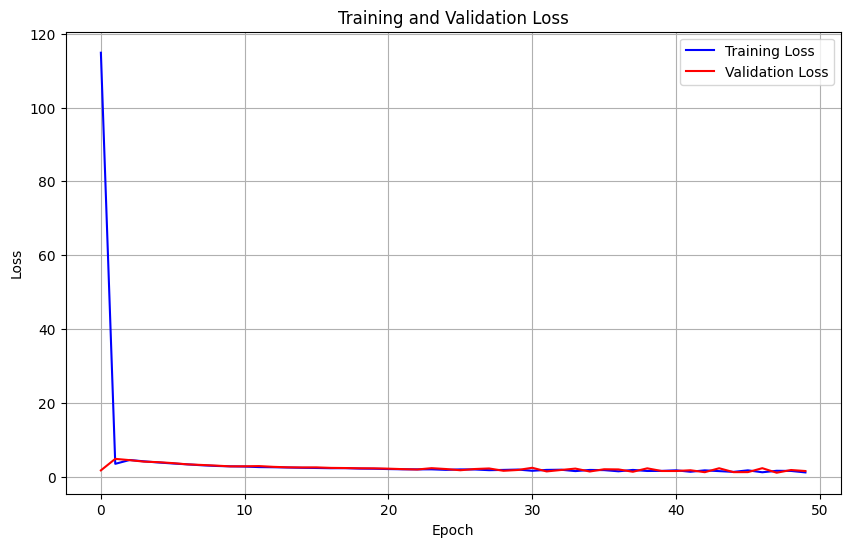

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, 'b-', label='Training Loss')
plt.plot(val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
user_norms = torch.norm(model.user_embedding.weight, dim=1)
avg_user_norm = torch.mean(user_norms) 
item_norms = torch.norm(model.item_embedding.weight, dim=1)
avg_item_norm = torch.mean(item_norms)

print("Average user embedding norm:", avg_user_norm.item())
print("Average item embedding norm:", avg_item_norm.item())

Average user embedding norm: 0.33922964334487915
Average item embedding norm: 0.9839776158332825


In [10]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'embedding_dim': model.user_embedding.embedding_dim,
        'dropout_rate': model.dropout.p,
        'bias': model.bias,
        'sigmoid': model.sigmoid,
    },
    'user_encoder': user_encoder,
    'track_encoder': track_encoder
}

torch.save(checkpoint, './model_files/wmf_model.pth')